# Curvy-CUSIPs: Marking your on Swaption Vol Surface

In [1]:
import sys
sys.path.append("../")

In [2]:
from CurvyCUSIPs.CurveDataFetcher import CurveDataFetcher
from CurvyCUSIPs.S490Swaps import S490Swaps
from CurvyCUSIPs.S490Swaptions import S490Swaptions
from CurvyCUSIPs.CurveInterpolator import GeneralCurveInterpolator

from pysabr import Hagan2002LognormalSABR, Hagan2002NormalSABR

from datetime import datetime
import pandas as pd
import QuantLib as ql
import numpy as np
import scipy as sp 
import seaborn as sns

from scipy.interpolate import RegularGridInterpolator
from scipy.interpolate import griddata
from scipy.interpolate import RectBivariateSpline
from scipy.interpolate import Rbf
from scipy.interpolate import interp1d

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
plt.style.use('ggplot')
params = {'legend.fontsize': 'x-large',
        'figure.figsize': (18, 10),
        'axes.labelsize': 'x-large',
        'axes.titlesize':'x-large',
        'xtick.labelsize':'x-large',
        'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

import nest_asyncio
nest_asyncio.apply()

%load_ext autoreload
%autoreload 2

In [3]:
curve_data_fetcher = CurveDataFetcher()

In [4]:
import os

# Get absolute path from notebook location
notebook_dir = os.path.dirname(os.path.abspath(''))
db_path = os.path.join(notebook_dir, "db", "nyclose_sofr_ois")
print(f"Looking for database at: {db_path}")
print(f"Path exists: {os.path.exists(db_path)}")
print(f"Path exists with .dat extension: {os.path.exists(db_path + '.dat')}")

# List contents of the db directory
db_dir = os.path.join(notebook_dir, "db")
print("\nContents of db directory:")
if os.path.exists(db_dir):
    print(os.listdir(db_dir))
else:
    print("db directory not found!")

Looking for database at: /home/peter/coding/swaps/Curvy-CUSIPs/db/nyclose_sofr_ois
Path exists: False
Path exists with .dat extension: True

Contents of db directory:
['ust_mid_ct_yields.bak', 'ust_cusip_timeseries.dat', 'ust_cusip_timeseries.dir', 'ust_mid_ct_yields.dat', 'ust_bid_ct_yields.dat', 'ust_cusip_set.bak', 's490_swaption_atm_vol.bak', 'ust_eod_ct_yields.bak', 'ust_cusip_set.dir', 'ust_bid_ct_yields.dir', 'ust_offer_ct_yields.dir', 'ust_offer_ct_yields.bak', 'nyclose_sofr_ois.bak', 'ust_eod_ct_yields.dir', 's490_swaption_atm_vol.dir', 's490_swaption_vol_cube.dat', 'dsb_upis', 's490_swaption_atm_vol.dat', 'nyclose_sofr_ois.dir', 'ust_bid_ct_yields.bak', 'ust_mid_ct_yields.dir', 'ust_offer_ct_yields.dat', 's490_swaption_vol_cube.dir', 'ust_cusip_set.dat', 'xlsx', 'ust_cusip_timeseries.bak', 'ust_eod_ct_yields.dat', 'nyclose_sofr_ois.dat', 's490_swaption_vol_cube.bak']


In [5]:
import os
notebook_dir = os.path.dirname(os.path.abspath(''))
db_path = os.path.join(notebook_dir, "db", "nyclose_sofr_ois")
print(f"Using database path: {db_path}")

Using database path: /home/peter/coding/swaps/Curvy-CUSIPs/db/nyclose_sofr_ois


In [6]:
s490_swaps = S490Swaps(s490_curve_db_path=db_path, curve_data_fetcher=curve_data_fetcher)
s490_swaptions = S490Swaptions(
    s490_swaps,
    
   # s490_vol_cube_markings_db_path="../db/yield_curve_monkey_vol_cube_markings_db",
  #  s490_atm_vol_grird_markings_db_path=r"../db/yield_curve_monkey_atm_vol_grid_markings_db",
 #   init_markings_db=True,
)

## Fetch Observed SOFR OIS Swaption Trades from DTCC SDR:
- We will data from the week of Nov 3 2024 in this example since we had the presidential election and a FOMC meeting
- We will have some numerical errors for some observed trades but lets ignore that for now

In [9]:
as_of_start_date = datetime(2025, 1, 17)
as_of_end_date = datetime(2025, 1, 27) 

sofr_ois_swaption_time_and_sales_dict, close_premium_dict, ql_curves_dict = s490_swaptions.create_s490_swaption_time_and_sales(
    start_date=as_of_start_date, 
    end_date=as_of_end_date, 
    data_fetcher=curve_data_fetcher, 
    model="normal"
)

swaptions_traded_df = pd.concat(list(sofr_ois_swaption_time_and_sales_dict.values())) 
swaptions_traded_df.tail(10)

URL: https://kgc0418-tdw-data-0.s3.amazonaws.com/cftc/eod/CFTC_CUMULATIVE_RATES_2025_01_24.zip
Status: 200
URL: https://kgc0418-tdw-data-0.s3.amazonaws.com/cftc/eod/CFTC_CUMULATIVE_RATES_2025_01_27.zip
Status: 200
URL: https://kgc0418-tdw-data-0.s3.amazonaws.com/cftc/eod/CFTC_CUMULATIVE_RATES_2025_01_21.zip
Status: 200
URL: https://kgc0418-tdw-data-0.s3.amazonaws.com/cftc/eod/CFTC_CUMULATIVE_RATES_2025_01_22.zip
Status: 200
URL: https://kgc0418-tdw-data-0.s3.amazonaws.com/cftc/eod/CFTC_CUMULATIVE_RATES_2025_01_17.zip
Status: 200
URL: https://kgc0418-tdw-data-0.s3.amazonaws.com/cftc/eod/CFTC_CUMULATIVE_RATES_2025_01_23.zip
Status: 200


/home/peter/coding/swaps/Curvy-CUSIPs/notebooks/../CurvyCUSIPs/DataFetcher/dtcc.py:238: DtypeWarning: Columns (57) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(f)
/home/peter/coding/swaps/Curvy-CUSIPs/notebooks/../CurvyCUSIPs/DataFetcher/dtcc.py:238: DtypeWarning: Columns (16,53,57,58,87,102,103) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(f)
/home/peter/coding/swaps/Curvy-CUSIPs/notebooks/../CurvyCUSIPs/DataFetcher/dtcc.py:238: DtypeWarning: Columns (53,57,103) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(f)
/home/peter/coding/swaps/Curvy-CUSIPs/notebooks/../CurvyCUSIPs/DataFetcher/dtcc.py:238: DtypeWarning: Columns (53) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(f)
/home/peter/coding/swaps/Curvy-CUSIPs/notebooks/../CurvyCUSIPs/DataFetcher/dtcc.py:238: DtypeWarning: Columns (53,102) ha

AttributeError: 'S490Swaps' object has no attribute 'build_sofr_ois_curve'

## What tenors were traded?

In [59]:
swaption_tenors_traded = (swaptions_traded_df["Option Tenor"] + "x" + swaptions_traded_df["Underlying Tenor"]).drop_duplicates().reset_index(drop=True)
swaption_tenors_traded

0       14Mx30Y
1        1Mx12M
2      2Y2Mx30Y
3        5Yx30Y
4        2Yx30Y
5     1150Dx30Y
6     10Y2Mx20Y
7       11Mx30Y
8        2Yx12M
9        1Mx30Y
10        3Mx5Y
11       2Yx10Y
12      257Dx5Y
13     257Dx10Y
14      15Yx10Y
15      12Mx12M
16       6Mx30Y
17      12Mx10Y
18       3Mx10Y
19      37Dx10Y
20    1697Dx10Y
21        1Mx5Y
22        6Mx5Y
23       6Mx10Y
24      10Yx20Y
25       2Yx20Y
26       3Yx12M
27       1Mx10Y
28       5Yx12M
29       6Mx25Y
30      138Dx5Y
31       2Mx10Y
32     1Y1Mx10Y
33       3Mx30Y
34       9Mx10Y
35      12Mx30Y
36     1Y3Mx10Y
37      10Yx10Y
38      20Yx10Y
39     6Y8Mx10Y
40       5Yx10Y
41      12Mx20Y
dtype: object

## ATM Swaption Grid:
- The "typical" swaption grid we see in sell side research notes or textbooks match the cash benchmark tenors, so we have 77 degrees of freedom if we assume independance
- Below is a visualization of what I'm talking about:


|     | 1y | 2y | 3y | 5y | 7y | 10y | 30y |
|-----|----|----|----|----|----|-----|-----|
| 1m  | x  | x  | x  | x  | x  | x   | x   |
| 3m  | x  | x  | x  | x  | x  | x   | x   |
| 6m  | x  | x  | x  | x  | x  | x   | x   |
| 1y  | x  | x  | x  | x  | x  | x   | x   |
| 2y  | x  | x  | x  | x  | x  | x   | x   |
| 3y  | x  | x  | x  | x  | x  | x   | x   |
| 4y  | x  | x  | x  | x  | x  | x   | x   |
| 5y  | x  | x  | x  | x  | x  | x   | x   |
| 10y | x  | x  | x  | x  | x  | x   | x   |
| 15y | x  | x  | x  | x  | x  | x   | x   |
| 30y | x  | x  | x  | x  | x  | x   | x   |


In [61]:
observed_atm_grid = {}

# we are assuming that the underlying distribution is Stochastic Gaussian/Normal
initial_beta = 0 
for swaption_tenor in swaption_tenors_traded:
    option_tenor, underlying_tenor = str(swaption_tenor).split("x")
    selected_swaption_df = swaptions_traded_df[
        (swaptions_traded_df["Option Tenor"] == option_tenor) & (swaptions_traded_df["Underlying Tenor"] == underlying_tenor)
    ]

    grouped = selected_swaption_df.groupby("Strike Price")
    average_vols = grouped["IV"].mean().reset_index()
    unique_strikes = average_vols["Strike Price"].values
    average_vols = average_vols["IV"].values / 100  

    F = selected_swaption_df["ATMF"].iloc[-1]
    T = ql.Period(option_tenor).length() / 12

    calibration_normal = Hagan2002NormalSABR(f=F, shift=0, t=T, beta=initial_beta).fit(unique_strikes, average_vols)
    alpha_calibrated, rho_calibrated, nu_calibrated = calibration_normal
    atm_vol = s490_swaptions.sabr_implied_vol(F, F, T, alpha=alpha_calibrated, beta=initial_beta, rho=rho_calibrated, nu=nu_calibrated) * 100
    observed_atm_grid[swaption_tenor] = (atm_vol * F) * 10000

KeyError: 'Column not found: IV'

In [8]:
observed_atm_grid

{'22Dx10Y': np.float64(99.8224323379805),
 '43Dx10Y': np.float64(99.85913296739227),
 '3Mx5Y': np.float64(123.5051744009014),
 '216Dx5Y': np.float64(122.91597163628329),
 '6Y9Mx10Y': np.float64(102.60652407098426),
 '10Yx20Y': np.float64(236.15327425549899),
 '216Dx2Y': np.float64(120.64153494668754),
 '2Yx10Y': np.float64(103.0380494224183),
 '1Mx30Y': np.float64(106.56585113406393),
 '74Dx30Y': np.float64(99.13102997327194),
 '47Mx5Y': np.float64(99.94653545028655),
 '12Mx12M': np.float64(123.65000459283297),
 '43Dx30Y': np.float64(106.39835604077922),
 '1Mx10Y': np.float64(224.7971236960918),
 '1Mx5Y': np.float64(116.21311122685111),
 '12Mx3Y': np.float64(223.95608688037098),
 '12Mx10Y': np.float64(100.91924988574894),
 '4Yx7Y': np.float64(198.78056024614713),
 '117Mx10Y': np.float64(99.718794431284),
 '2Y1Mx10Y': np.float64(110.912065382383),
 '5Yx30Y': np.float64(105.96602501150225),
 '6Mx5Y': np.float64(111.10498658336223),
 '12Dx10Y': np.float64(99.99989578726692),
 '202Dx30Y': 

## Interpolation:
- Now that we have our observed ATM vol, lets interpolate these normal vols so that we can get our standard grid
- Were going to be using scipy for the first part
- Describing our observed ATM vol data as sparse is a vast understatement
- Below, we will show a process/framework that will give us a reasonable surface for research purposes
- Explore arb-free construction techniques? 

In [9]:
def parse_key(key):
    option_tenor, underlying_tenor = key.split("x")
    return ql.Period(option_tenor).normalized().length() / 12, ql.Period(underlying_tenor).normalized().length()

### Linear Interpolation:

In [10]:
records = [parse_key(k) + (v,) for k, v in observed_atm_grid.items()]
df = pd.DataFrame(records, columns=["Option_Maturity_Months", "Swap_Tenor_Years", "Vol"])
option_maturities = sorted(df["Option_Maturity_Months"].unique())
swap_tenors = sorted(df["Swap_Tenor_Years"].unique())

option_grid = sorted([1, 3, 6, 12, 24, 36, 48, 60, 72, 84, 120])  # in months
swap_grid = sorted([1, 2, 3, 5, 7, 10, 30])  # in years

pivot_table = df.pivot_table(index="Option_Maturity_Months", columns="Swap_Tenor_Years", values="Vol").sort_index()

sorted_option = np.sort(pivot_table.index.values)
sorted_swap = np.sort(pivot_table.columns.values)

points = df[["Option_Maturity_Months", "Swap_Tenor_Years"]].values
values = df["Vol"].values
option_grid_array, swap_grid_array = np.meshgrid(option_grid, swap_grid, indexing="ij")

vol_grid_bilinear = griddata(points, values, (option_grid_array, swap_grid_array), method="linear")
grid_bilinear = pd.DataFrame(vol_grid_bilinear, index=option_grid, columns=swap_grid)
grid_bilinear


# print("Bilinear Interpolation Grid:")
# print(grid_bilinear)
# plt.figure(figsize=(18, 8))
# sns.heatmap(grid_bilinear, annot=True, fmt=".6f", cmap="viridis", xticklabels=swap_grid, yticklabels=option_grid)
# plt.title("Standard ATM Swaption Volatility Grid - Bilinear Interpolation")
# plt.xlabel("Swap Tenor (Years)")
# plt.ylabel("Option Maturity (Months)")
# plt.show()

# fig = plt.figure(figsize=(14, 10))
# ax = fig.add_subplot(111, projection='3d')
# # surf = ax.plot_surface(option_grid_array, swap_grid_array, grid_bilinear, cmap='viridis', edgecolor='k', alpha=0.7)
# ax.scatter(df["Option_Maturity_Months"], df["Swap_Tenor_Years"], df["Vol"], color='red', s=50, label='Observed Data')
# ax.set_title('Standard ATM Swaption Volatility Grid - Bilinear Interpolation', fontsize=16)
# ax.set_xlabel('Option Maturity (Months)', fontsize=12)
# ax.set_ylabel('Swap Tenor (Years)', fontsize=12)
# ax.set_zlabel('Volatility', fontsize=12)
# # fig.colorbar(surf, shrink=0.5, aspect=10, label='Volatility')
# ax.legend()
# ax.view_init(elev=30, azim=225)
# plt.show()



,1,2,3,5,7,10,30
1,99.983271,99.964127,150.888067,109.472043,179.675442,99.999896,101.037579
3,99.943195,99.942479,99.947139,102.940266,122.360088,104.157496,105.187858
6,NaN,103.306052,103.189424,102.382359,100.096083,101.672109,99.599890
12,NaN,111.973793,111.857165,109.397533,106.578313,105.198871,102.098158
24,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48,NaN,NaN,NaN,NaN,NaN,NaN,NaN
60,NaN,NaN,NaN,NaN,NaN,NaN,NaN
72,NaN,NaN,NaN,NaN,NaN,NaN,NaN
84,NaN,NaN,NaN,NaN,NaN,NaN,NaN


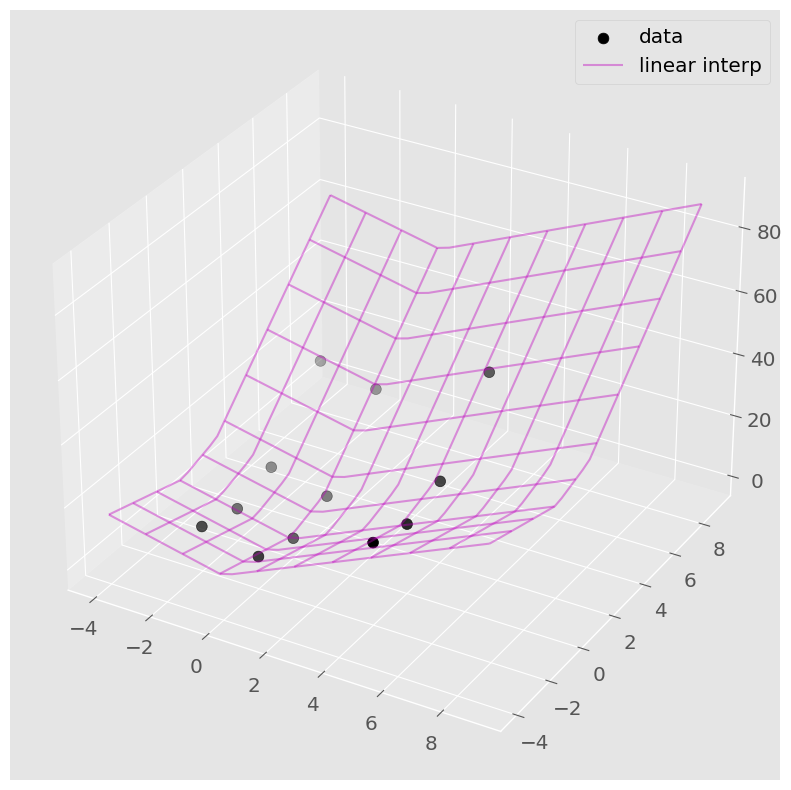

In [11]:
from scipy.interpolate import RegularGridInterpolator
import numpy as np


x, y = np.array([-2, 0, 4]), np.array([-2, 0, 2, 5])


def ff(x, y):
    return x**2 + y**2


xg, yg = np.meshgrid(x, y, indexing="ij")
data = ff(xg, yg)
interp = RegularGridInterpolator((x, y), data, bounds_error=False, fill_value=None)

import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.scatter(xg.ravel(), yg.ravel(), data.ravel(), s=60, c="k", label="data")

xx = np.linspace(-4, 9, 31)
yy = np.linspace(-4, 9, 31)
X, Y = np.meshgrid(xx, yy, indexing="ij")
ax.plot_wireframe(X, Y, interp((X, Y)), rstride=3, cstride=3, alpha=0.4, color="m", label="linear interp")
plt.legend()
plt.show()

## Below is an interactive SABR Model:

### These are the params I use for my own markings 

- Swaption Tenor: 1y10y
- ATMF Mark:	0.036343
- SABR Beta: 	0
- SABR Alpha:	0.0001
- SABR Rho:	0.204136
- SABR Nu:	0.636904

In [12]:
[t for t in observed_atm_grid.keys() if "3M" in t.split("x")[0]]

['3Mx5Y', '3Mx12M', '3Mx10Y']

In [21]:
s490_swaptions.create_sabr_smile_interactive(
    swaption_time_and_sales=sofr_ois_swaption_time_and_sales_dict[as_of_start_date],
    option_tenor="12M",
    underlying_tenor="10Y",
    initial_beta=0.5,
    show_trades=True,
    scale_by_notional=False,
    model="normal",
    implementation="rss",
    year_day_count=252,
    ploty_height=1250,
    receiver_skew_anchor_bpvol=0.01,
    payer_skew_anchor_bpvol=0.75,
    anchor_weight=25,
    skew_offset_anchor_bps=100,
    drop_trades_idxs=[22, 23, 8, 9] # these are unrealitically low, removing them
)

,Event timestamp,Direction,Style,Notional Amount,Strike Price,OTM,Option Premium per Notional,IV,IV bp/day,ATMF,UPI FISN,UPI Underlier Name
0,2024-11-07 17:09:41,underwritter,receiver,10000000.0,0.03850,8.628619,0.03200,103.736181,6.534765,0.037637,NA/O P Epn OIS USD,NA/Swap OIS USD
1,2024-11-07 17:09:54,underwritter,payer,10000000.0,0.03850,8.628619,0.03200,103.736181,6.534765,0.037637,NA/O Call Epn OIS USD,NA/Swap OIS USD
2,2024-11-07 12:04:22,buyer,payer,25500000.0,0.03927,16.328619,0.03390,113.075840,7.123108,0.037637,NA/O Call Epn OIS USD,NA/Swap OIS USD
3,2024-11-07 12:04:22,buyer,receiver,25500000.0,0.03927,16.328619,0.03390,113.075840,7.123108,0.037637,NA/O P Epn OIS USD,NA/Swap OIS USD
4,2024-11-07 14:03:32,buyer,payer,25000000.0,0.03900,13.628619,0.03355,110.329736,6.950120,0.037637,NA/O Call Epn OIS USD,NA/Swap OIS USD
5,2024-11-07 14:03:32,buyer,receiver,25000000.0,0.03900,13.628619,0.03355,110.329736,6.950120,0.037637,NA/O P Epn OIS USD,NA/Swap OIS USD
6,2024-11-07 14:13:54,buyer,payer,25000000.0,0.03890,12.628619,0.03355,109.718074,6.911589,0.037637,NA/O Call Epn OIS USD,NA/Swap OIS USD
7,2024-11-07 14:13:54,buyer,receiver,25000000.0,0.03890,12.628619,0.03355,109.718074,6.911589,0.037637,NA/O P Epn OIS USD,NA/Swap OIS USD
10,2024-11-07 14:51:00,buyer,payer,25000000.0,0.03873,10.928619,0.03335,108.042158,6.806016,0.037637,NA/O Call Epn OIS USD,NA/Swap OIS USD
11,2024-11-07 14:51:00,buyer,receiver,25000000.0,0.03873,10.928619,0.03335,108.042158,6.806016,0.037637,NA/O P Epn OIS USD,NA/Swap OIS USD


RuntimeError: rho square must be less than one: 19.9938 not allowed

Current 12M Vol Data in s490_vol_cube_markings_db: {'12Mx12M': np.float64(7.752), '12Mx2Y': np.float64(7.479), '12Mx3Y': np.float64(7.199), '12Mx10Y': np.float64(6.643), '12Mx20Y': np.float64(6.3)}
Current 12M SABR Params s490_vol_cube_markings_db: {
    "12Mx10Y": {
        "sabr_beta": 0.49999999999999994,
        "sabr_alpha": 0.000525,
        "sabr_rho": -0.02744599999999997,
        "sabr_nu": 0.6518
    },
    "12Mx2Y": {
        "sabr_beta": 0.49999999999999994,
        "sabr_alpha": 0.0005959999999999999,
        "sabr_rho": -0.3364710000000001,
        "sabr_nu": 0.715108
    },
    "12Mx12M": {
        "sabr_beta": 0.49999999999999994,
        "sabr_alpha": 0.000633,
        "sabr_rho": -0.388127,
        "sabr_nu": 0.41655000000000003
    },
    "12Mx3Y": {
        "sabr_beta": 0.49999999999999994,
        "sabr_alpha": 0.0005759999999999999,
        "sabr_rho": -0.2632460000000001,
        "sabr_nu": 0.6648339999999999
    },
    "12Mx20Y": {
        "sabr_beta": 0.4999999

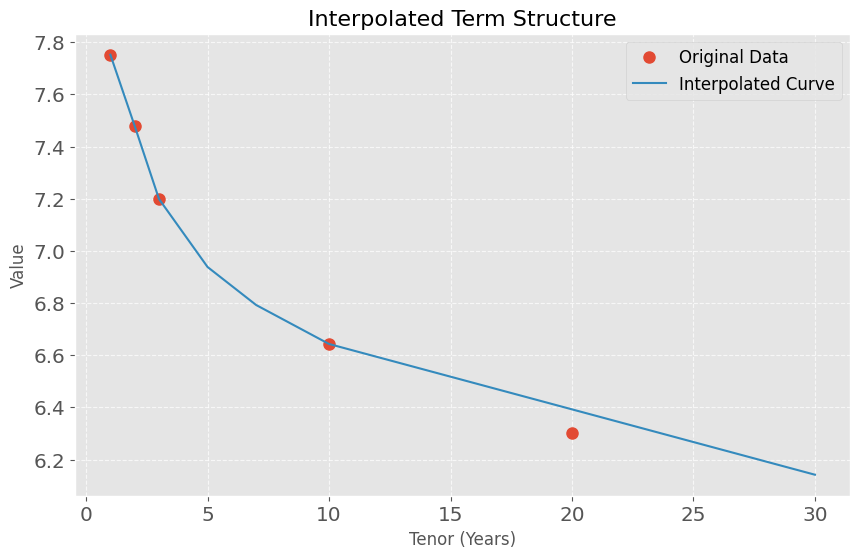

Interpolated ATM Row: {
    "1": 7.752,
    "2": 7.11,
    "3": 7.199000000000001,
    "5": 6.938171668667467,
    "7": 6.792437146287086,
    "10": 6.642999999999999,
    "30": 6.141773109243698
}
Wrote ATM Term Structure for 12M on 2024-11-07


In [222]:
s490_swaptions._mark_s490_atm_vol_term_structure_markings_db(
    date=as_of_start_date, option_maturity="12M", vol_type="bp_vol", show_plot=True, gci_interp_func_str="monotone_convex", hard_coded_vols={2: 7.11}
)

In [221]:
s490_swaptions.plot_s490_atm_vol_term_structure_markings_db(date=as_of_start_date, option_maturity="12M", vol_type="bp_vol")

ValueError: 12M on 2024-11-07 not in s490_atm_vol_grid_markings_db!